In [ ]:
author__ = "Chloé Lagrue"
__email__ = "lagruech@gmail.com"
__status__ = "Last Name Generator -- RNN"

# Name Generation Usign an RNN

## Data pre-processing 

There are 18 languages in our dataset:


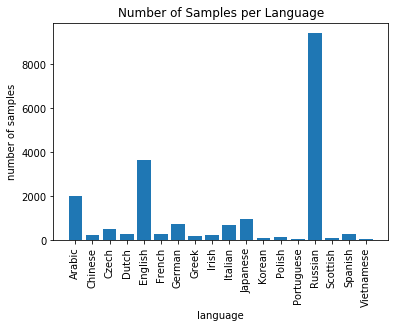

In [1]:
import glob
import re
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters)+1

# OPEN THE DATA INTO A DICTIONARY
paths = glob.glob("data/names/*.txt")
data = dict()
for path in paths:
    language = re.search("data/names/(\w+)\.txt",path).group(1)
    data[language] = list()
    f = open(path,'r')
    for name in f.readlines():
        name = name.replace('\n','')
        name = unicodedata.normalize('NFD',name).encode('ascii','replace')
        name = ''.join([c for c in str(name)[2:-1] if c in all_letters])
        data[language].append(name)
    f.close()
    
    
#=========== PRINTING ZONE ===========#
import matplotlib.pyplot as plt
%matplotlib inline

print("There are",len(data),"languages in our dataset:")

x,y = list(),list()

for language in data:
    x.append(language)
    y.append(len(data[language]))

plt.title("Number of Samples per Language")
plt.xlabel("language")
plt.ylabel("number of samples")
plt.bar(x,y)
plt.xticks(rotation='vertical')
plt.show()

So we can see that Arabic, English, and Russian have a lot more samples than other languages, so we might expect more efficiency in those languages.

Here are the functions we're going to use to pre-process our data to fit into the RNN:

In [2]:
import torch
import string
import numpy as np


# EMBEDDINGS

def languageTensor(language):
    languages = np.array(list(data.keys()))
    tensor = torch.zeros(1,languages.shape[0])
    tensor[0][np.where(languages==language)[0][0]] = 1
    return tensor

def inputTensor(name):
    tensor = torch.zeros(len(name),1,n_letters)
    for ni in range(len(name)):
        letter = name[ni]
        tensor[ni][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(name):
    letter_indexes = [all_letters.find(name[ni]) for ni in range(1, len(name))]
    letter_indexes.append(n_letters - 1) 
    return torch.LongTensor(letter_indexes)


# GET RANDOM SAMPLE

def get_random_sample():
    language = np.random.choice(list(data.keys()))
    name = np.random.choice(data[language])
    return language,name

def convert_sample(language,name):
    language = languageTensor(language)
    in_put = inputTensor(name)
    target = targetTensor(name)
    return language,in_put,target

def get_data_point():
    language,name = get_random_sample()
    return convert_sample(language,name)


#=========== PRINTING ZONE ===========#
print("List of languages:")
print(', '.join(list(data.keys())))
print("\nRepresentation of English as one-hot tensor:")
print(np.array(languageTensor('English')[0]))
print("Representation of German as one-hot tensor:")
print(np.array(languageTensor('German')[0]))
print("\nRandom samples from the dataset:")
for _ in range(10):
    language,name = get_random_sample()
    print("\tLanguage:",language,"\tName:",name)

List of languages:
Spanish, German, Italian, Polish, Dutch, Russian, Greek, Arabic, Japanese, Irish, Chinese, Vietnamese, Korean, Portuguese, French, Czech, Scottish, English

Representation of English as one-hot tensor:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Representation of German as one-hot tensor:
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Random samples from the dataset:
	Language: Italian 	Name: Caito
	Language: Dutch 	Name: Herten
	Language: Scottish 	Name: Mckay
	Language: French 	Name: Gage
	Language: Czech 	Name: Kosko
	Language: Scottish 	Name: Mckenzie
	Language: Italian 	Name: Salomon
	Language: Greek 	Name: Hadjiyianakies
	Language: Polish 	Name: Pakulski
	Language: Irish 	Name: Riain


## RNN class

In [3]:
import torch.nn as nn


class RNN(nn.Module):


    def __init__(self,n_languages,input_size,hidden_size,output_size):

        super(RNN,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(n_languages+input_size+hidden_size,hidden_size)
        self.i2o = nn.Linear(n_languages+input_size+hidden_size,output_size)
        self.o2o = nn.Linear(hidden_size+output_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.1)


    def forward(self,language,in_put,hidden):
        input_combined = torch.cat((language,in_put,hidden),1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden,output),1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output,hidden


    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

## Training the RNN

0 / 200000 		loss: 4.0538581848144535
10000 / 200000 		loss: 3.9836977178400215
20000 / 200000 		loss: 2.3264753341674806
30000 / 200000 		loss: 2.4008614676339284
40000 / 200000 		loss: 3.0182806650797525
50000 / 200000 		loss: 2.4181360517229353
60000 / 200000 		loss: 1.7572110493977864
70000 / 200000 		loss: 2.2118093317205254
80000 / 200000 		loss: 2.1021739112006292
90000 / 200000 		loss: 2.6051697731018066
100000 / 200000 		loss: 2.293194135030111
110000 / 200000 		loss: 1.438603401184082
120000 / 200000 		loss: 2.828159809112549
130000 / 200000 		loss: 2.2869499206542967
140000 / 200000 		loss: 1.906400203704834
150000 / 200000 		loss: 2.076725482940674
160000 / 200000 		loss: 1.6124951498849052
170000 / 200000 		loss: 2.637394428253174
180000 / 200000 		loss: 2.1790897846221924
190000 / 200000 		loss: 2.340540313720703


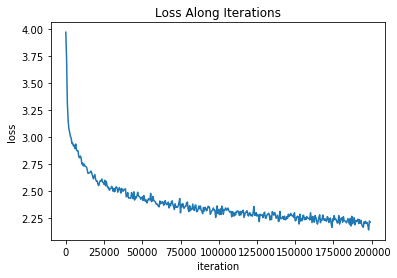

In [4]:
def train(language_tensor,input_tensor,target_tensor):
    target_tensor = target_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = 0
    for i in range(input_tensor.size(0)):
        output,hidden = rnn(language_tensor,input_tensor[i],hidden)
        l = loss_model(output,target_tensor[i])
        loss += l
    loss.backward()
    for p in rnn.parameters(): p.data.add_(-lr,p.grad.data)
    return output, loss.item()/input_tensor.size(0)


loss_model = nn.NLLLoss()
lr = .0005
rnn = RNN(len(data),n_letters,128,n_letters)
n_iters = 200000
print_every = 10000
plot_every = 500
all_losses = []
total_loss = 0.

for i in range(n_iters):
    output,loss = train(*get_data_point())
    total_loss += loss

    if i%print_every==0: print(i,'/',n_iters,'\t\tloss:',loss)
    if i%plot_every==0 and i!=0: 
        all_losses.append(total_loss/plot_every)
        total_loss = 0.
        
plt.title('Loss Along Iterations')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(np.arange(len(all_losses))*plot_every,all_losses);

In [5]:
max_name_length = 20

def generate_name(language,first_letter):
    with torch.no_grad():
        language_tensor = languageTensor(language)
        input_tensor = inputTensor(first_letter)
        output_name = first_letter
        for i in range(max_name_length):
            hidden = rnn.initHidden()
            for j in range(input_tensor.size(0)): 
                output,hidden = rnn(language_tensor,input_tensor[j],hidden)
            topv,topi = output.topk(1)
            topi = topi[0][0]
            if topi==n_letters-1: break
            else:
                letter = all_letters[topi]
                output_name+=letter
            input_tensor = inputTensor(output_name)
        return output_name
    
def generate_names(language,first_letters):
    names = [generate_name(language,first_letter) for first_letter in first_letters]
    print(language,'names:',', '.join(names))
        

generate_names('Russian','RUSIA')
generate_names('Italian','ITALY')
generate_names('German','GERMANY')
generate_names('Chinese','CHINA')
generate_names('Japanese','JAPN')

Russian names: Rovakov, Uakovanov, Shaveveven, Irishiv, Allandov
Italian names: Iangali, Tongali, Albangili, Lacon, Yarichi
German names: Graser, Eren, Rousher, Macher, Arthur, Naher, Youner
Chinese names: Cau, Han, Iun, Nia, Ana
Japanese names: Janako, Angauda, Paka, Nakama


## Generate without a First Letter

In [6]:
def updatedInputTensor(name):
    name = ';'+name
    tensor = torch.zeros(len(name),1,n_letters)
    for ni in range(len(name)):
        letter = name[ni]
        tensor[ni][0][all_letters.find(letter)] = 1
    return tensor

def updatedTargetTensor(name):
    letter_indexes = [all_letters.find(name[ni]) for ni in range(len(name))]
    letter_indexes.append(n_letters - 1) 
    return torch.LongTensor(letter_indexes)

def updated_convert_sample(language,name):
    language = languageTensor(language)
    in_put = updatedInputTensor(name)
    target = updatedTargetTensor(name)
    return language,in_put,target

def updated_get_data_point():
    language,name = get_random_sample()
    return updated_convert_sample(language,name)

0 / 200000 		loss: 4.113009452819824
10000 / 200000 		loss: 2.888819013323103
20000 / 200000 		loss: 2.328965902328491
30000 / 200000 		loss: 2.285438749525282
40000 / 200000 		loss: 1.9699331919352214
50000 / 200000 		loss: 3.562310218811035
60000 / 200000 		loss: 2.6855459213256836
70000 / 200000 		loss: 2.5310241154261996
80000 / 200000 		loss: 3.141601138644748
90000 / 200000 		loss: 2.2005836963653564
100000 / 200000 		loss: 1.8155810492379325
110000 / 200000 		loss: 2.8775386810302734
120000 / 200000 		loss: 2.1791691098894392
130000 / 200000 		loss: 2.8895460764567056
140000 / 200000 		loss: 2.175044059753418
150000 / 200000 		loss: 1.3410539627075195
160000 / 200000 		loss: 2.3554340998331704
170000 / 200000 		loss: 2.3207074945623223
180000 / 200000 		loss: 3.0633978843688965
190000 / 200000 		loss: 1.9872312545776367


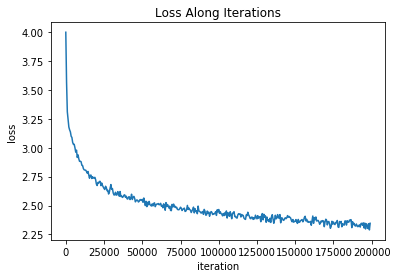

In [7]:
def updated_train(language_tensor,input_tensor,target_tensor):
    target_tensor = target_tensor.unsqueeze_(-1)
    hidden = updated_rnn.initHidden()
    updated_rnn.zero_grad()
    loss = 0
    for i in range(input_tensor.size(0)):
        output,hidden = updated_rnn(language_tensor,input_tensor[i],hidden)
        l = loss_model(output,target_tensor[i])
        loss += l
    loss.backward()
    for p in updated_rnn.parameters(): p.data.add_(-lr,p.grad.data)
    return output, loss.item()/input_tensor.size(0)

loss_model = nn.NLLLoss()
lr = .0005
updated_rnn = RNN(len(data),n_letters,128,n_letters)
n_iters = 200000
print_every = 10000
plot_every = 500
all_losses = []
total_loss = 0.

for i in range(n_iters):
    output,loss = updated_train(*updated_get_data_point())
    total_loss += loss

    if i%print_every==0: print(i,'/',n_iters,'\t\tloss:',loss)
    if i%plot_every==0 and i!=0: 
        all_losses.append(total_loss/plot_every)
        total_loss = 0.
        
plt.title('Loss Along Iterations')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(np.arange(len(all_losses))*plot_every,all_losses);

In [10]:
max_name_length = 20

def generate_name(language):
    with torch.no_grad():
        language_tensor = languageTensor(language)
        input_tensor = inputTensor(';')
        output_name = ';'
        for i in range(max_name_length):
            hidden = updated_rnn.initHidden()
            for j in range(input_tensor.size(0)): 
                output,hidden = updated_rnn(language_tensor,input_tensor[j],hidden)
            topv,topi = output.topk(1)
            topi = topi[0][0]
            if topi==n_letters-1: break
            else:
                letter = all_letters[topi]
                output_name+=letter
            input_tensor = inputTensor(output_name)
        return output_name[1:]
    
for language in np.sort(list(data.keys())):
    print(language+':',generate_name(language))

Arabic: Samara
Chinese: Sha
Czech: Koura
Dutch: Santer
English: Marden
French: Bares
German: Scher
Greek: Kostilos
Irish: Machala
Italian: Alaci
Japanese: Kasama
Korean: Son
Polish: Sowako
Portuguese: Mareu
Russian: Allay
Scottish: Schill
Spanish: Alaras
Vietnamese: Thang


## Adding Variety to Generations

One problem with our generative model is it always generates the same names for a fixed first letter. Ideally, that wouldn't be a thing. 
We're going to add randomness to our hidden vector in our RNN to add a sense of randomness and so variety to our generated names. 

### New RNN Class

To change our hidden vector, we'll need to define a new RNN class. 

In [24]:
import torch.nn as nn


class random_RNN(nn.Module):


    def __init__(self,n_languages,input_size,hidden_size,output_size):

        super(random_RNN,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(n_languages+input_size+hidden_size,hidden_size)
        self.i2o = nn.Linear(n_languages+input_size+hidden_size,output_size)
        self.o2o = nn.Linear(hidden_size+output_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.1)


    def forward(self,language,in_put,hidden):
        input_combined = torch.cat((language,in_put,hidden),1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden,output),1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output,hidden


    def initHidden(self):
        return torch.from_numpy(np.random.randn(1,self.hidden_size)).type('torch.FloatTensor')

0 / 200000 		loss: 4.028178351266043
10000 / 200000 		loss: 2.5103530883789062
20000 / 200000 		loss: 3.072185198465983
30000 / 200000 		loss: 2.7409440994262697
40000 / 200000 		loss: 2.0408871514456615
50000 / 200000 		loss: 2.1144484111240933
60000 / 200000 		loss: 2.1947814396449496
70000 / 200000 		loss: 2.8398404802594865
80000 / 200000 		loss: 2.336313941261985
90000 / 200000 		loss: 2.542799862948331
100000 / 200000 		loss: 2.7782405853271483
110000 / 200000 		loss: 2.2454198201497397
120000 / 200000 		loss: 2.517642550998264
130000 / 200000 		loss: 2.480553150177002
140000 / 200000 		loss: 2.489656925201416
150000 / 200000 		loss: 2.497265625
160000 / 200000 		loss: 2.278669902256557
170000 / 200000 		loss: 2.3756316502889
180000 / 200000 		loss: 2.603526496887207
190000 / 200000 		loss: 2.9145046869913735


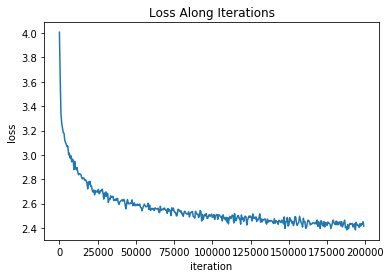

In [30]:
def random_train(language_tensor,input_tensor,target_tensor):
    target_tensor = target_tensor.unsqueeze_(-1)
    hidden = random_rnn.initHidden()
    random_rnn.zero_grad()
    loss = 0
    for i in range(input_tensor.size(0)):
        output,hidden = random_rnn(language_tensor,input_tensor[i],hidden)
        l = loss_model(output,target_tensor[i])
        loss += l
    loss.backward()
    for p in random_rnn.parameters(): p.data.add_(-lr,p.grad.data)
    return output, loss.item()/input_tensor.size(0)

loss_model = nn.NLLLoss()
lr = .0005
random_rnn = random_RNN(len(data),n_letters,128,n_letters)
n_iters = 200000
print_every = 10000
plot_every = 500
all_losses = []
total_loss = 0.

for i in range(n_iters):
    output,loss = random_train(*updated_get_data_point())
    total_loss += loss

    if i%print_every==0: print(i,'/',n_iters,'\t\tloss:',loss)
    if i%plot_every==0 and i!=0: 
        all_losses.append(total_loss/plot_every)
        total_loss = 0.
        
plt.title('Loss Along Iterations')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(np.arange(len(all_losses))*plot_every,all_losses);

In [39]:
max_name_length = 20

def generate_name(language):
    with torch.no_grad():
        language_tensor = languageTensor(language)
        input_tensor = inputTensor(';')
        output_name = ';'
        for i in range(max_name_length):
            hidden = random_rnn.initHidden()
            for j in range(input_tensor.size(0)): 
                output,hidden = random_rnn(language_tensor,input_tensor[j],hidden)
            topv,topi = output.topk(1)
            topi = topi[0][0]
            if topi==n_letters-1: break
            else:
                letter = all_letters[topi]
                output_name+=letter
            input_tensor = inputTensor(output_name)
        return output_name[1:]
    
for language in np.sort(list(data.keys())):
    names = ', '.join([generate_name(language) for _ in range(3)])
    print(language+': '+names)

Arabic: Sanam, Sanda, Shara
Chinese: Shin, Shin, Chan
Czech: Molle, Schant, Schall
Dutch: Scheren, Keren, Schelen
English: Banten, Malle, Manger
French: Berre, Lever, Lanter
German: Scher, Scher, Berren
Greek: Kontas, Kallas, Pallos
Irish: Dangen, O'Mallan, O'Den
Italian: Arton, Alberi, Allon
Japanese: Scaka, Kamakam, Kamaka
Korean: Sno, Sho, San
Polish: Sckoll, Sckilow, Sandak
Portuguese: baresto, Santero, Mares
Russian: Banden, Devellov, Bantov
Scottish: Mcher, Machel, Mander
Spanish: Maran, Salla, Alla
Vietnamese: Than, Than, Than
